In [1]:
import torch
import torch.nn as nn

#Network implementation
class SSM(nn.Module):
    def __init__(self, sequence_size, hidden_size, output_size, dtype = torch.float32):
        super(SSM, self).__init__()
        self.A = nn.Linear(sequence_size, hidden_size, dtype= dtype)
        self.B = nn.Linear(sequence_size, hidden_size, dtype= dtype)
        self.C = nn.Linear(hidden_size, output_size, dtype= dtype)
        self.D = nn.Linear(sequence_size, output_size, dtype= dtype)
        #self.H = torch.zeros(hidden_size, dtype=dtype)
        self.register_buffer('H', torch.zeros(hidden_size, dtype=dtype))
    
    def forward(self, x):
        self.H.detach_()
        self.H = torch.relu(self.A(x)).diag() @ self.H + torch.sigmoid(self.B(x)) 

        y = self.C(torch.sigmoid(self.H)) + self.D(x)
        
        return y


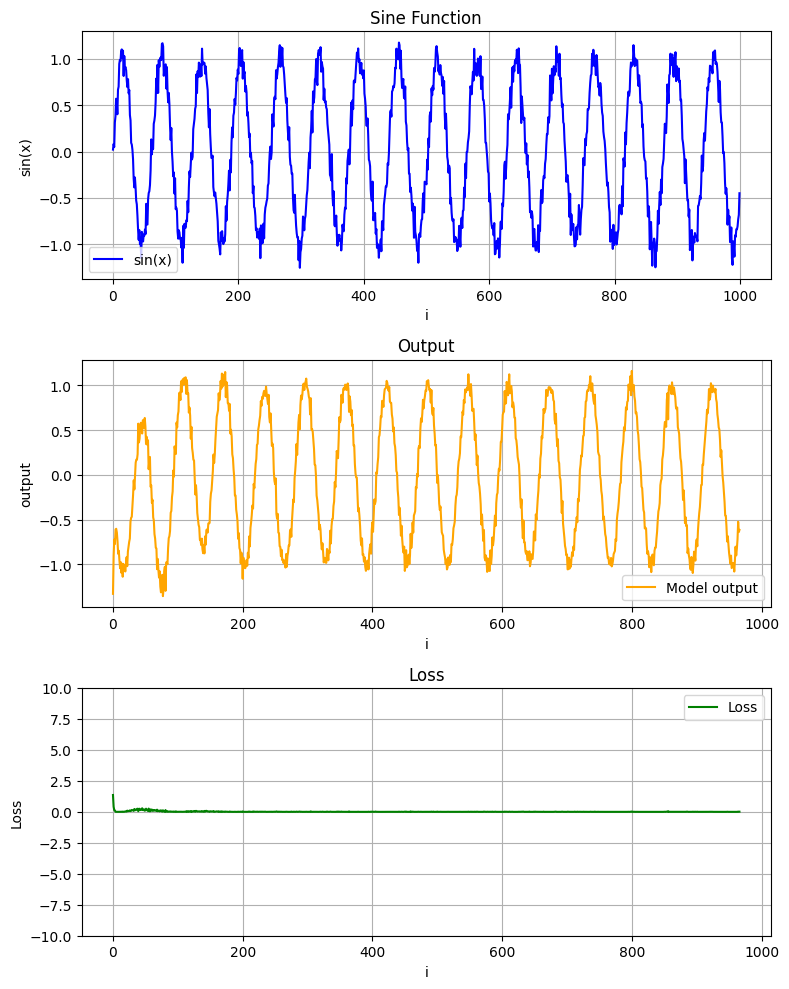

In [2]:
b = SSM(sequence_size=32, hidden_size=1, output_size=1)
samples = torch.sin(torch.linspace(start=0, end=100, steps=1000, dtype=torch.float32)) + torch.randn(1000) * torch.tensor([.1])
sine = torch.sin(torch.linspace(start=0, end=100, steps=1000, dtype=torch.float32))
optimizer = torch.optim.SGD(b.parameters(), lr = 0.01)
losses = []
output = []
for i in range(1000 - 33):
    b.zero_grad()
    x = samples[i: i+ 32]
    y = b(x)
    output.append(y.item())
    y = (y - sine[i+ 33]).pow(2)
    y.backward()
    losses.append(y.item())
    optimizer.step()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 10))

axs[0].plot(samples.tolist(), color='blue', label='sin(x)')
axs[0].set_title('Sine Function')
axs[0].set_xlabel('i')
axs[0].set_ylabel('sin(x)')
axs[0].legend()
axs[0].grid()

# Plot the second graph
axs[1].plot(output, color='orange', label='Model output')
axs[1].set_title('Output')
axs[1].set_xlabel('i')
axs[1].set_ylabel('output')
axs[1].legend()
axs[1].grid()

# Plot the third graph
axs[2].plot(losses, color='green', label='Loss')
axs[2].set_title('Loss')
axs[2].set_xlabel('i')
axs[2].set_ylabel('Loss')
axs[2].set_ylim(-10, 10)  # Limit y-axis to avoid extreme values
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

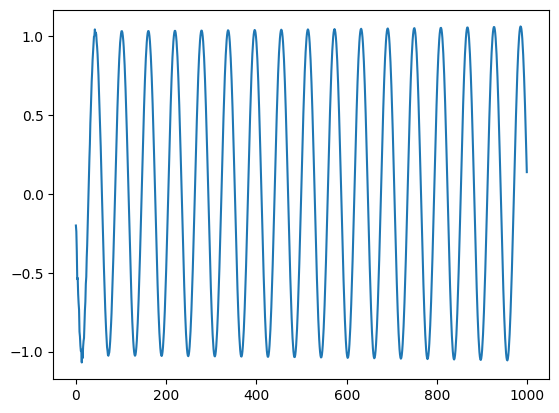

In [3]:
test_x = torch.tensor([samples[i] for i in range(32)], dtype=torch.float32)
o = []
for i in range(1000):
    with torch.no_grad():
        y = b(test_x)
        test_x = torch.cat((test_x[1:],y))
        o.append(y)

plt.plot(o)